# Task 1 : Set up colab gpu runtime environment

In [ ]:
#!pip install segmentation-models-pytorch
#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install --upgrade opencv-contrib-python

# Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [81]:
#!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

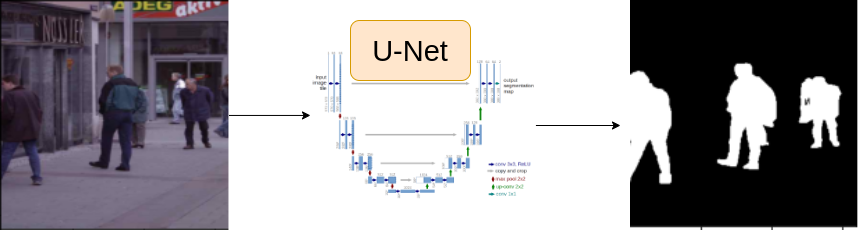

# Some Common Imports

In [82]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [83]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

Setup Configurations

In [84]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003 #learn rate
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [85]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
#Reads an image and mask from the first row of a DataFrame, converts the image to RGB, and normalizes the grayscale mask for further processing.
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

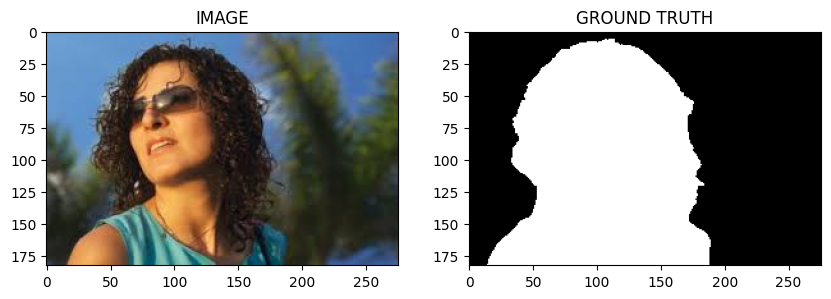

In [ ]:
#Creates a side-by-side plot with the image titled "IMAGE" and the grayscale mask titled "GROUND TRUTH."
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [88]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [89]:
import albumentations as A

In [90]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ], is_check_shapes=False)

# Create Custom Dataset

In [91]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h,w,c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [93]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [94]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


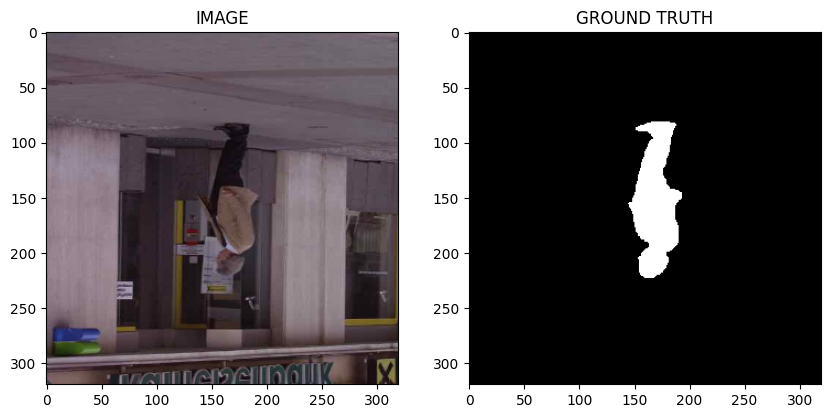

In [105]:
idx = 5

image, mask = trainset[idx]
helper.show_image(image, mask)

# Load dataset into batches

In [96]:
from torch.utils.data import DataLoader

In [97]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [98]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [99]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [100]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [101]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [102]:
model = SegmentationModel()
model.to(DEVICE);

# Create Train and Validation Function

In [103]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [106]:
def eval_fn(data_loader, model):

  model.train()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Train Model

In [107]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [108]:
best_valid_loss = np.inf

for epoch in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("saved model:")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1} train loss: {train_loss} valid loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


saved model:
Epoch : 1 train loss: 0.7456618984540303 valid loss: 0.4579159989953041


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


saved model:
Epoch : 2 train loss: 0.3438170780738195 valid loss: 0.3698039874434471


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 3 train loss: 0.2984372178713481 valid loss: 0.3978760093450546


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


Epoch : 4 train loss: 0.29704836308956145 valid loss: 0.4085617922246456


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch : 5 train loss: 0.2216980367898941 valid loss: 0.3881344832479954


100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


saved model:
Epoch : 6 train loss: 0.24053282042344412 valid loss: 0.34909017384052277


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


saved model:
Epoch : 7 train loss: 0.19755013585090636 valid loss: 0.2959480956196785


100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Epoch : 8 train loss: 0.19285628994305928 valid loss: 0.3368556462228298


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch : 9 train loss: 0.17965593785047532 valid loss: 0.3539334647357464


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


saved model:
Epoch : 10 train loss: 0.18401606678962706 valid loss: 0.28757261857390404


100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


Epoch : 11 train loss: 0.1583948199947675 valid loss: 0.33180152624845505


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch : 12 train loss: 0.14704560736815134 valid loss: 0.32615599036216736


100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


Epoch : 13 train loss: 0.13103760530551276 valid loss: 0.3717825338244438


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Epoch : 14 train loss: 0.11816276758909225 valid loss: 0.3767669051885605


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch : 15 train loss: 0.13057816276947656 valid loss: 0.33405379205942154


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


saved model:
Epoch : 16 train loss: 0.11446190426747004 valid loss: 0.28191425651311874


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 17 train loss: 0.1579555427034696 valid loss: 0.34520500153303146


100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


Epoch : 18 train loss: 0.2092455635468165 valid loss: 0.39075079932808876


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch : 19 train loss: 0.17309010724226634 valid loss: 0.3705397769808769


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


Epoch : 20 train loss: 0.16950128674507142 valid loss: 0.29027265310287476


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 21 train loss: 0.14584429313739142 valid loss: 0.3635699786245823


100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


Epoch : 22 train loss: 0.12146380295356114 valid loss: 0.35883060842752457


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Epoch : 23 train loss: 0.10441257953643798 valid loss: 0.3606247082352638


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


Epoch : 24 train loss: 0.11722020556529363 valid loss: 0.29530293494462967


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

Epoch : 25 train loss: 0.12885381082693736 valid loss: 0.3333991803228855


# Inference

In [110]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-110-2639ded4aea8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


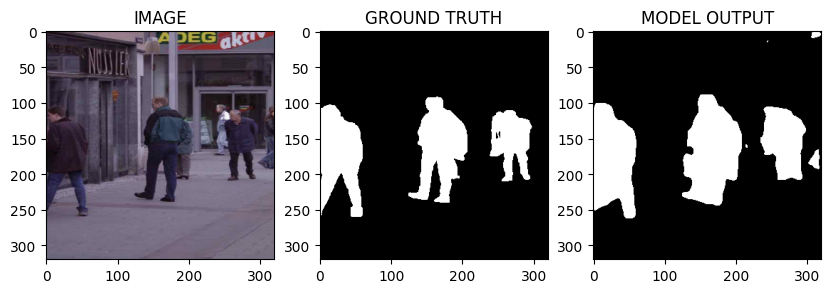

In [113]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))